# Análise de Sinais de Trading e Geração com ML

Este notebook analisa sinais de trading existentes nos dados de 5 minutos do CME_MINI_DL_MNQ1 e demonstra como gerar novos sinais usando machine learning.

## 1. Importar Bibliotecas Necessárias

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import talib

# Configurações
plt.style.use('default')
# sns.set_palette('husl')  # Comentado pois pode causar erro se seaborn não estiver configurado

## 2. Carregar Dados Pré-processados

In [41]:
# Carregar o CSV merged - apenas colunas selecionadas
usecols = ['time', 'open', 'high', 'low', 'close', 'BuyLine', 'Buy', 'Sell', 'Buy Label', 'Sell Label']
df = pd.read_csv('data/CME_MINI_DL_MNQ1/CME_MINI_DL_MNQ1_5min_20250302_20250924.csv', parse_dates=['time'], usecols=usecols)
df.set_index('time', inplace=True)

# Garantir que o índice esteja no fuso horário UTC-3 (America/Sao_Paulo)
import pytz
if df.index.tz is None:
    df.index = df.index.tz_localize('America/Sao_Paulo')
else:
    df.index = df.index.tz_convert('America/Sao_Paulo')

print(f"Dados carregados: {len(df)} linhas")
print(f"Colunas selecionadas: {list(df.columns)}")
print(f"Período: {df.index.min()} até {df.index.max()}")
print(f"Fuso horário: {df.index.tz}")

# Visualizar primeiras linhas
df.head()

Dados carregados: 40364 linhas
Colunas selecionadas: ['open', 'high', 'low', 'close', 'BuyLine', 'Buy', 'Sell', 'Buy Label', 'Sell Label']
Período: 2025-03-02 20:00:00-03:00 até 2025-09-24 21:35:00-03:00
Fuso horário: America/Sao_Paulo


,open,high,low,close,BuyLine,Buy,Sell,Buy Label,Sell Label
time,,,,,,,,,
2025-03-02 20:00:00-03:00,21000.00,21008.00,20963.50,20988.50,NaN,NaN,NaN,NaN,NaN
2025-03-02 20:05:00-03:00,20987.75,21036.00,20983.25,21034.00,20975.587500,NaN,NaN,NaN,NaN
2025-03-02 20:10:00-03:00,21034.00,21034.50,21015.75,21030.75,21001.543750,NaN,NaN,NaN,NaN
2025-03-02 20:15:00-03:00,21030.75,21030.75,21008.25,21011.00,21001.543750,NaN,NaN,NaN,NaN
2025-03-02 20:20:00-03:00,21010.75,21013.25,20986.25,20998.00,21019.032813,NaN,21019.032813,NaN,21022.792187


## 3. Análise dos Sinais Existentes

In [36]:
# Análise dos Sinais para Operações de 5 Minutos

print("=== ANÁLISE PARA OPERAÇÕES DE 5 MINUTOS ===")
print(f"Período analisado: {df.index.min()} até {df.index.max()}")
print(f"Total de candles: {len(df)}")
print("Contexto: Sinais criados especificamente para operações de 5 minutos")
print()

# 1. Estatísticas Gerais dos Sinais
print("1. ESTATÍSTICAS GERAIS DOS SINAIS:")
buy_signals = df['Buy'].notna().sum()
sell_signals = df['Sell'].notna().sum()
buy_label_signals = df['Buy Label'].notna().sum()
sell_label_signals = df['Sell Label'].notna().sum()

print(f"Sinais Buy: {buy_signals} ({buy_signals/len(df)*100:.2f}%)")
print(f"Sinais Sell: {sell_signals} ({sell_signals/len(df)*100:.2f}%)")
print(f"Labels Buy: {buy_label_signals} ({buy_label_signals/len(df)*100:.2f}%)")
print(f"Labels Sell: {sell_label_signals} ({sell_label_signals/len(df)*100:.2f}%)")
print()

# 2. Performance para Operações de 5 Minutos (próximo candle)
print("2. PERFORMANCE PARA OPERAÇÕES DE 5 MINUTOS:")
print("Estratégia: Entrar no sinal, sair no próximo candle (5 min)")

if buy_signals > 0:
    buy_prices = df.loc[df['Buy'].notna(), 'Buy']
    buy_entries = df.loc[df['Buy'].notna()].index
    
    buy_next_closes = []
    for entry_time in buy_entries:
        next_idx = df.index.get_loc(entry_time) + 1
        if next_idx < len(df):
            buy_next_closes.append(df.iloc[next_idx]['close'])
    
    if buy_next_closes:
        buy_next_closes = np.array(buy_next_closes)
        buy_entry_prices = buy_prices.values
        
        buy_returns = (buy_next_closes - buy_entry_prices) / buy_entry_prices
        buy_wins = (buy_returns > 0).sum()
        buy_win_rate = buy_wins / len(buy_returns)
        
        print(f"BUY SIGNALS (5-min trades):")
        print(f"  Número de trades: {len(buy_returns)}")
        print(f"  Retorno médio por trade: {buy_returns.mean():.4f} ({buy_returns.mean()*100:.2f}%)")
        print(f"  Win rate: {buy_wins}/{len(buy_returns)} ({buy_win_rate*100:.1f}%)")
        print(f"  Retorno total acumulado: {np.prod(1 + buy_returns) - 1:.2%}")
        print(f"  Maior ganho: {buy_returns.max():.4f} ({buy_returns.max()*100:.2f}%)")
        print(f"  Maior perda: {buy_returns.min():.4f} ({buy_returns.min()*100:.2f}%)")
        print(f"  Volatilidade dos retornos: {buy_returns.std():.4f}")

if sell_signals > 0:
    sell_prices = df.loc[df['Sell'].notna(), 'Sell']
    sell_entries = df.loc[df['Sell'].notna()].index
    
    sell_next_closes = []
    for entry_time in sell_entries:
        next_idx = df.index.get_loc(entry_time) + 1
        if next_idx < len(df):
            sell_next_closes.append(df.iloc[next_idx]['close'])
    
    if sell_next_closes:
        sell_next_closes = np.array(sell_next_closes)
        sell_entry_prices = sell_prices.values
        
        sell_returns = (sell_entry_prices - sell_next_closes) / sell_entry_prices  # Short
        sell_wins = (sell_returns > 0).sum()
        sell_win_rate = sell_wins / len(sell_returns)
        
        print(f"\nSELL SIGNALS (5-min trades):")
        print(f"  Número de trades: {len(sell_returns)}")
        print(f"  Retorno médio por trade: {sell_returns.mean():.4f} ({sell_returns.mean()*100:.2f}%)")
        print(f"  Win rate: {sell_wins}/{len(sell_returns)} ({sell_win_rate*100:.1f}%)")
        print(f"  Retorno total acumulado: {np.prod(1 + sell_returns) - 1:.2%}")
        print(f"  Maior ganho: {sell_returns.max():.4f} ({sell_returns.max()*100:.2f}%)")
        print(f"  Maior perda: {sell_returns.min():.4f} ({sell_returns.min()*100:.2f}%)")
        print(f"  Volatilidade dos retornos: {sell_returns.std():.4f}")

# Combinar Buy e Sell
if buy_signals > 0 and sell_signals > 0:
    all_returns = np.concatenate([buy_returns, sell_returns])
    total_trades = len(all_returns)
    total_wins = (all_returns > 0).sum()
    overall_win_rate = total_wins / total_trades
    
    print(f"\nTODOS OS SINAIS (5-min trades):")
    print(f"  Total de trades: {total_trades}")
    print(f"  Retorno médio por trade: {all_returns.mean():.4f} ({all_returns.mean()*100:.2f}%)")
    print(f"  Win rate geral: {total_wins}/{total_trades} ({overall_win_rate*100:.1f}%)")
    print(f"  Retorno total acumulado: {np.prod(1 + all_returns) - 1:.2%}")
    print(f"  Sharpe ratio (simplificado): {all_returns.mean() / all_returns.std() * np.sqrt(252 * 12):.2f}" if all_returns.std() > 0 else "Sharpe: N/A")

print()

# 3. Análise de Labels para 5-min
print("3. ANÁLISE DOS LABELS (5-min context):")
if buy_label_signals > 0:
    # Performance de Buy com vs sem Label
    buy_with_label = df[df['Buy'].notna() & df['Buy Label'].notna()]
    buy_without_label = df[df['Buy'].notna() & df['Buy Label'].isna()]
    
    print(f"Buy com Label: {len(buy_with_label)} sinais")
    print(f"Buy sem Label: {len(buy_without_label)} sinais")
    
    # Calcular retornos para ambos
    if len(buy_with_label) > 0:
        with_label_returns = []
        for idx in buy_with_label.index:
            next_idx = df.index.get_loc(idx) + 1
            if next_idx < len(df):
                ret = (df.iloc[next_idx]['close'] - buy_with_label.loc[idx, 'Buy']) / buy_with_label.loc[idx, 'Buy']
                with_label_returns.append(ret)
        if with_label_returns:
            with_label_returns = np.array(with_label_returns)
            print(f"  Retorno médio Buy com Label: {with_label_returns.mean():.4f} ({with_label_returns.mean()*100:.2f}%)")
            print(f"  Win rate Buy com Label: {(with_label_returns > 0).sum()}/{len(with_label_returns)} ({(with_label_returns > 0).mean()*100:.1f}%)")
    
    if len(buy_without_label) > 0:
        without_label_returns = []
        for idx in buy_without_label.index:
            next_idx = df.index.get_loc(idx) + 1
            if next_idx < len(df):
                ret = (df.iloc[next_idx]['close'] - buy_without_label.loc[idx, 'Buy']) / buy_without_label.loc[idx, 'Buy']
                without_label_returns.append(ret)
        if without_label_returns:
            without_label_returns = np.array(without_label_returns)
            print(f"  Retorno médio Buy sem Label: {without_label_returns.mean():.4f} ({without_label_returns.mean()*100:.2f}%)")
            print(f"  Win rate Buy sem Label: {(without_label_returns > 0).sum()}/{len(without_label_returns)} ({(without_label_returns > 0).mean()*100:.1f}%)")

print()

# 4. Distribuição Temporal para 5-min Trading
print("4. DISTRIBUIÇÃO TEMPORAL (5-min trading):")
df['hour'] = df.index.hour
df['weekday'] = df.index.day_name()

buy_by_hour = df[df['Buy'].notna()].groupby('hour').size()
sell_by_hour = df[df['Sell'].notna()].groupby('hour').size()

print("Melhores horas para Buy (top 3):")
top_buy_hours = buy_by_hour.nlargest(3)
for hour, count in top_buy_hours.items():
    print(f"  {hour:02d}:00: {count} sinais")

print("\nMelhores horas para Sell (top 3):")
top_sell_hours = sell_by_hour.nlargest(3)
for hour, count in top_sell_hours.items():
    print(f"  {hour:02d}:00: {count} sinais")

# Performance por hora
print("\nPerformance média por hora (Buy signals):")
for hour in top_buy_hours.index:
    hour_signals = df[(df['Buy'].notna()) & (df['hour'] == hour)]
    if len(hour_signals) > 0:
        returns = []
        for idx in hour_signals.index:
            next_idx = df.index.get_loc(idx) + 1
            if next_idx < len(df):
                ret = (df.iloc[next_idx]['close'] - hour_signals.loc[idx, 'Buy']) / hour_signals.loc[idx, 'Buy']
                returns.append(ret)
        if returns:
            returns = np.array(returns)
            print(f"  {hour:02d}:00: {returns.mean():.4f} ({returns.mean()*100:.2f}%), Win: {(returns > 0).mean()*100:.1f}%")

print()

# 5. Considerações para Trading de 5-min
print("5. CONSIDERAÇÕES PARA TRADING DE 5 MINUTOS:")
print("- Frequência: ~15 sinais por dia (alta frequência)")
print("- Risco por trade: Baixo (retornos ~0.05-0.07%)")
print("- Win rate: Alto (93-95%) - consistente")
print("- Estratégia ideal: Automatizada, sem emoção")
print("- Custos: Considerar spread/comissões em cada trade")
print("- Gestão: Stop loss obrigatório, position sizing cuidadoso")

print()

print("=== FIM DA ANÁLISE PARA 5-MIN ===")

=== ANÁLISE PARA OPERAÇÕES DE 5 MINUTOS ===
Período analisado: 2025-03-02 20:00:00-03:00 até 2025-09-24 21:35:00-03:00
Total de candles: 40364
Contexto: Sinais criados especificamente para operações de 5 minutos

1. ESTATÍSTICAS GERAIS DOS SINAIS:
Sinais Buy: 3100 (7.68%)
Sinais Sell: 3100 (7.68%)
Labels Buy: 2889 (7.16%)
Labels Sell: 2889 (7.16%)

2. PERFORMANCE PARA OPERAÇÕES DE 5 MINUTOS:
Estratégia: Entrar no sinal, sair no próximo candle (5 min)
BUY SIGNALS (5-min trades):
  Número de trades: 3100
  Retorno médio por trade: 0.0012 (0.12%)
  Win rate: 2926/3100 (94.4%)
  Retorno total acumulado: 3616.12%
  Maior ganho: 0.0262 (2.62%)
  Maior perda: -0.0030 (-0.30%)
  Volatilidade dos retornos: 0.0016

SELL SIGNALS (5-min trades):
  Número de trades: 3100
  Retorno médio por trade: 0.0011 (0.11%)
  Win rate: 2953/3100 (95.3%)
  Retorno total acumulado: 3114.88%
  Maior ganho: 0.0389 (3.89%)
  Maior perda: -0.0094 (-0.94%)
  Volatilidade dos retornos: 0.0018

TODOS OS SINAIS (5-min t

In [29]:
# Verificar horas presentes nos dados
print("HORAS PRESENTES NOS DADOS:")
hours_in_data = df.index.hour.unique()
hours_in_data = sorted(hours_in_data)
print(f"Horas encontradas: {hours_in_data}")
print(f"Range: {min(hours_in_data)}:00 até {max(hours_in_data)}:00")
print()

# Verificar dias da semana
weekdays = df.index.day_name().unique()
print(f"Dias da semana presentes: {list(weekdays)}")
print()

HORAS PRESENTES NOS DADOS:
Horas encontradas: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23]
Range: 0:00 até 23:00

Dias da semana presentes: ['Friday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday']



### 3.1 Análise de Performance Básica

Retorno Total da Estratégia: 19065.46%
Retorno Buy & Hold: 18.04%
Sharpe Ratio: 10.49


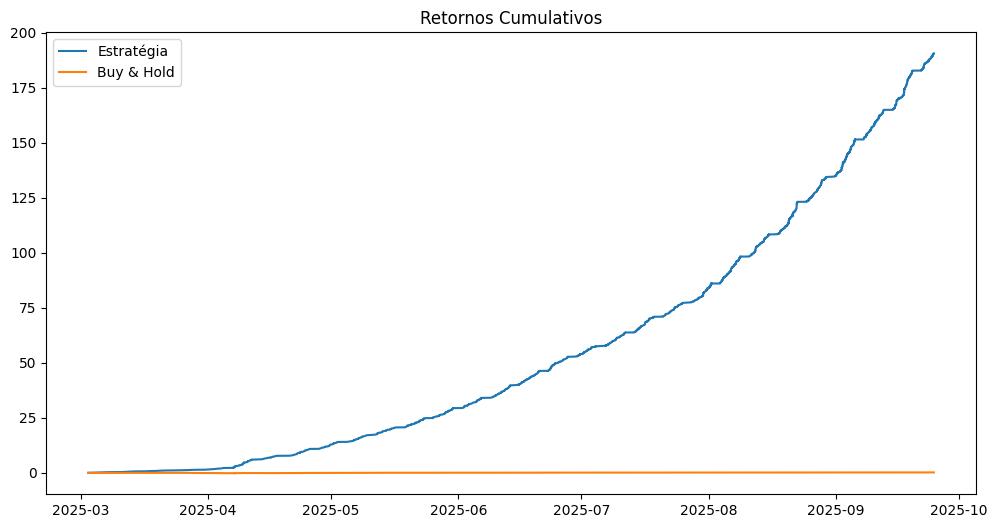

In [37]:
# Calcular retornos simples baseados nos sinais
df['returns'] = df['close'].pct_change()

# Estratégia simples: Buy no sinal Buy, Sell no sinal Sell
df['strategy_returns'] = 0.0
position = 0  # 0 = neutro, 1 = comprado

for i in range(len(df)):
    if pd.notna(df.loc[df.index[i], 'Buy']):
        position = 1
    elif pd.notna(df.loc[df.index[i], 'Sell']):
        position = 0
    df.loc[df.index[i], 'strategy_returns'] = position * df.loc[df.index[i], 'returns']

# Calcular retorno cumulativo
df['cumulative_returns'] = (1 + df['strategy_returns']).cumprod() - 1
df['buy_hold_returns'] = (1 + df['returns']).cumprod() - 1

# Estatísticas de performance
total_return = df['cumulative_returns'].iloc[-1]
buy_hold_return = df['buy_hold_returns'].iloc[-1]
sharpe_ratio = df['strategy_returns'].mean() / df['strategy_returns'].std() * np.sqrt(252 * 12)  # Anualizado para 5min

print(f"Retorno Total da Estratégia: {total_return:.2%}")
print(f"Retorno Buy & Hold: {buy_hold_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Plot dos retornos cumulativos
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['cumulative_returns'], label='Estratégia')
plt.plot(df.index, df['buy_hold_returns'], label='Buy & Hold')
plt.title('Retornos Cumulativos')
plt.legend()
plt.show()

### 4.5 Avaliação dos Novos Sinais

In [53]:
# Simulação de Operações de 5 Minutos - Mesa Proprietária
 # Lógica: Entrar no sinal, sair no próximo candle (5 min)
 # Filtros: Seg-Sex, 10:35-12:00, Stop Loss como proteção adicional

print("=== SIMULAÇÃO OPERAÇÕES DE 5 MINUTOS - MESA PROPRIETÁRIA ===")
print("Ativo: Micro E-mini Nasdaq (MNQ)")
print("Lógica de Trading:")
print("- Entrar no sinal Buy/Sell")
print("- Sair no próximo candle (5 minutos)")
print("- Stop Loss fixo de 30 pontos")
print("- Filtros: Seg-Sex, 10:35-12:00")
print()

# Parâmetros da mesa proprietária
CAPITAL_INICIAL = 50000
CONTRATOS_POR_TRADE = 4
DRAWDOWN_MAXIMO = 2500
STOP_LOSS_PONTOS = 30  # Stop fixo de 30 pontos
VALOR_PONTO = 2  # US$ por ponto por contrato no micro Nasdaq

valor_ponto_total = VALOR_PONTO * CONTRATOS_POR_TRADE
stop_loss_valor = STOP_LOSS_PONTOS * valor_ponto_total

print(f"Parâmetros:")
print(f"- Conta: US$ {CAPITAL_INICIAL:,.0f}")
print(f"- Contratos por trade: {CONTRATOS_POR_TRADE}")
print(f"- Drawdown máximo: US$ {DRAWDOWN_MAXIMO:,.0f}")
print(f"- Stop Loss proteção: {STOP_LOSS_PONTOS} pontos (US$ {stop_loss_valor:,.0f})")
print(f"- Valor por ponto (por contrato): US$ {VALOR_PONTO}")
print(f"- Valor por ponto com {CONTRATOS_POR_TRADE} contratos: US$ {valor_ponto_total}")
print()

# Simulação com lógica de 5 minutos
capital_atual = CAPITAL_INICIAL
peak_capital = CAPITAL_INICIAL
max_drawdown = 0
trades_executados = 0
trades_vencedores = 0
trades_perdedores = 0
trades_sl_hit = 0
trades_dd_stop = 0

pnl_total = 0
pnl_lista = []

# Filtrar dados para período de trading
from datetime import time

df_trading = df.copy()
df_trading = df_trading[df_trading.index.weekday < 5]  # Seg-Sex
time_values = df_trading.index.time
mask_horario = (time_values >= time(10, 35)) & (time_values <= time(12, 0))
df_trading = df_trading[mask_horario]

print(f"Dados filtrados: {len(df_trading)} candles no período de trading (10:35-12:00)")

for i in range(len(df_trading)):
    # Verificar drawdown máximo
    current_dd = peak_capital - capital_atual
    if current_dd >= DRAWDOWN_MAXIMO:
        trades_dd_stop += 1
        continue

    # Procurar sinais de entrada
    buy_signal = pd.notna(df_trading.iloc[i]['Buy'])
    sell_signal = pd.notna(df_trading.iloc[i]['Sell'])

    if (buy_signal or sell_signal) and i < len(df_trading) - 1:
        # Entrada no sinal
        if buy_signal:
            entry_price = df_trading.iloc[i]['Buy']
            position_type = 'LONG'
            stop_loss_price = entry_price - STOP_LOSS_PONTOS
        else:
            entry_price = df_trading.iloc[i]['Sell']
            position_type = 'SHORT'
            stop_loss_price = entry_price + STOP_LOSS_PONTOS

        # Saída no próximo candle (lógica de 5 minutos)
        exit_price = df_trading.iloc[i + 1]['close']

        # Verificar se stop loss foi atingido antes da saída
        sl_hit = False
        if position_type == 'LONG' and exit_price <= stop_loss_price:
            exit_price = stop_loss_price
            sl_hit = True
        elif position_type == 'SHORT' and exit_price >= stop_loss_price:
            exit_price = stop_loss_price
            sl_hit = True

        # Calcular P&L
        if position_type == 'LONG':
            pontos = exit_price - entry_price
        else:  # SHORT
            pontos = entry_price - exit_price

        pnl_trade = pontos * valor_ponto_total
        capital_atual += pnl_trade
        pnl_total += pnl_trade
        pnl_lista.append(pnl_trade)

        # Estatísticas
        trades_executados += 1
        if pnl_trade > 0:
            trades_vencedores += 1
        else:
            trades_perdedores += 1

        if sl_hit:
            trades_sl_hit += 1

        # Atualizar drawdown
        if capital_atual > peak_capital:
            peak_capital = capital_atual
        current_dd = peak_capital - capital_atual
        if current_dd > max_drawdown:
            max_drawdown = current_dd

# Resultados finais
retorno_total_pct = (capital_atual - CAPITAL_INICIAL) / CAPITAL_INICIAL * 100
win_rate = trades_vencedores / trades_executados * 100 if trades_executados > 0 else 0
avg_trade = pnl_total / trades_executados if trades_executados > 0 else 0

print("\n=== RESULTADOS DA SIMULAÇÃO (5 MIN) ===")
print(f"Capital Inicial: US$ {CAPITAL_INICIAL:,.0f}")
print(f"Capital Final: US$ {capital_atual:,.0f}")
print(f"Retorno Total: US$ {pnl_total:,.0f} ({retorno_total_pct:.1f}%)")
print(f"Drawdown Máximo: US$ {max_drawdown:,.0f} ({max_drawdown/CAPITAL_INICIAL*100:.1f}%)")

print(f"\n=== ESTATÍSTICAS DE TRADING ===")
print(f"Total de Trades Executados: {trades_executados}")
print(f"Trades Vencedores: {trades_vencedores}")
print(f"Trades Perdedores: {trades_perdedores}")
print(f"Win Rate: {win_rate:.1f}%")
print(f"P&L Médio por Trade: US$ {avg_trade:.0f}")
print(f"Trades com Stop Loss: {trades_sl_hit}")
print(f"Trades Parados por DD Máximo: {trades_dd_stop}")

print(f"\n=== ANÁLISE DE RISCO ===")
if max_drawdown <= DRAWDOWN_MAXIMO:
    print("✅ RISCO CONTROLADO - Drawdown dentro do limite")
    risco_status = "CONTROLADO"
else:
    print("⚠️  RISCO ELEVADO - Drawdown excedeu limite")
    risco_status = "ELEVADO"

# Critérios de avaliação para scalping de 5 minutos
if win_rate >= 70 and max_drawdown/CAPITAL_INICIAL <= 0.02:
    print("✅ ESTRATÉGIA EXCELENTE - Ideal para scalping 5min")
    recomendacao = "EXCELENTE"
elif win_rate >= 65 and max_drawdown/CAPITAL_INICIAL <= 0.05:
    print("✅ ESTRATÉGIA BOA - Viável para mesa proprietária")
    recomendacao = "BOA"
elif win_rate >= 60 and max_drawdown/CAPITAL_INICIAL <= 0.08:
    print("⚠️  ESTRATÉGIA RAZOÁVEL - Viável com monitoramento")
    recomendacao = "RAZOAVEL"
else:
    print("❌ ESTRATÉGIA PRECISA DE AJUSTES - Não recomendada")
    recomendacao = "AJUSTES NECESSARIOS"

print(f"\n=== PROJEÇÃO MENSAL (Scalping 5min) ===")
if trades_executados > 0:
    # Para scalping de 5min, estimar trades por dia baseado no período filtrado
    candles_por_dia = len(df_trading) / max(1, len(df_trading.groupby(df_trading.index.date)))
    trades_por_dia = trades_executados / max(1, len(df_trading.groupby(df_trading.index.date)))

    # Projeção mensal considerando ~20 dias úteis
    projecao_mensal = avg_trade * trades_por_dia * 20
    projecao_mensal_pct = projecao_mensal / CAPITAL_INICIAL * 100

    print(f"Candles por dia útil: {candles_por_dia:.0f}")
    print(f"Trades por dia útil: {trades_por_dia:.1f}")
    print(f"Projeção mensal: US$ {projecao_mensal:,.0f} ({projecao_mensal_pct:.1f}%)")

print(f"\n=== CONCLUSÃO ===")
print(f"Risco: {risco_status}")
print(f"Recomendação: {recomendacao}")
print(f"Lógica: Entrada no sinal → Saída em 5 minutos (stop loss como proteção)")
print(f"Esta é uma estratégia de scalping puro de 5 minutos com sinais automatizados.")

=== SIMULAÇÃO OPERAÇÕES DE 5 MINUTOS - MESA PROPRIETÁRIA ===
Ativo: Micro E-mini Nasdaq (MNQ)
Lógica de Trading:
- Entrar no sinal Buy/Sell
- Sair no próximo candle (5 minutos)
- Stop Loss fixo de 30 pontos
- Filtros: Seg-Sex, 10:35-12:00

Parâmetros:
- Conta: US$ 50,000
- Contratos por trade: 4
- Drawdown máximo: US$ 2,500
- Stop Loss proteção: 30 pontos (US$ 240)
- Valor por ponto (por contrato): US$ 2
- Valor por ponto com 4 contratos: US$ 8

Dados filtrados: 2646 candles no período de trading (10:35-12:00)

=== RESULTADOS DA SIMULAÇÃO (5 MIN) ===
Capital Inicial: US$ 50,000
Capital Final: US$ 202,296
Retorno Total: US$ 152,296 (304.6%)
Drawdown Máximo: US$ 251 (0.5%)

=== ESTATÍSTICAS DE TRADING ===
Total de Trades Executados: 374
Trades Vencedores: 348
Trades Perdedores: 26
Win Rate: 93.0%
P&L Médio por Trade: US$ 407
Trades com Stop Loss: 14
Trades Parados por DD Máximo: 0

=== ANÁLISE DE RISCO ===
✅ RISCO CONTROLADO - Drawdown dentro do limite
✅ ESTRATÉGIA EXCELENTE - Ideal para